In [1]:
## Import libraries
import numpy as np
import pandas as pd
import yaml
import sys
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./utils')

## Import helper modules
from sanity_check import * 
from swiss_tournament import *
from train_val_test_split import *
from vif import *
from transformation import *
from gbm_rel_feature_importance import *

In [3]:
#Read the parameters file  
with open("params.yml", 'r') as f:
    params = yaml.safe_load(f)

#Path to dataset    
data_path= params['input_data_path']

#Sanity check parameters
sanity_check_dict = params['sanity_check']
null_threshold = sanity_check_dict['null_threshold']
num_of_std = sanity_check_dict['num_of_std']
variance_threshold = sanity_check_dict['variance_threshold']
impute_method = sanity_check_dict['impute_method']

#Train, Validation and Test split parameters
split_dict = params['train_valid_test_split']
train_size = split_dict['train_size']
val_size = split_dict['val_size']

#Swiss tournament random forest iteraions parameters
no_of_rf = params['no_of_rf']
feature_each_rf= params['feature_each_rf']
max_depth= params['max_depth']
n_estimators= params['n_estimators']

#classify features as high and low importance based on percentile
percentile=params['percentile']

#R-squared threshold for vif removal function
r_square_threshold = params['r_square_threshold']

#GBM GridSearchCV parameters
max_depth_l = params['max_depth_l']
min_samples_split_l = params['min_samples_split_l']
n_estimators_l = params['n_estimators_l']
learning_rate_l = params['learning_rate_l']

In [4]:
#Read dataset
df = pd.read_csv(data_path)

#### PERFORM SANITY CHECKS ON DATA

In [5]:
sanity_df=sanity_checks(df.copy(),null_threshold,impute_method,num_of_std,variance_threshold)

Data has 4296 columns.
There are 3124 columns that have missing values
Null value report saved as Null_values_report.csv!! 

1836 features have nulls greater than the threshold and will be dropped
Dropped features saved in report Null_Dropped_Report.csv!! 

Imputation performed using fill_forward

Outliers are capped between [upper-lower] bound using standard deviation method.

0 features with 0 variance found and dropped
Dropped Low variance features saved in Low_Variance_Features_Report.csv!!

Number of features remaining: 2460


#### SPLIT DATA INTO TRAIN, VALIDATION AND TEST

In [6]:
# Train and Test Split
train = sanity_df.iloc[0:100,:]
test = sanity_df.iloc[100:,:]


In [7]:
#Create independent variable
x = train.drop(['Close^IXIC'],axis=1)
y = train['Close^IXIC']

#### PERFORM SWISS TOURNAMENT ITERATIONS

In [8]:
report_df,rank_df = Swiss_tourney(x,y,no_of_rf,feature_each_rf,max_depth,n_estimators)

Running 5000 Random Forests with 30 features each!


100%|██████████| 5000/5000 [06:25<00:00, 13.31it/s]


Feature importance reports generated and saved as rank.csv and Feature_Importance_Report.csv!


In [9]:
report_df.head()

,feature,feature_imp_sum,feature_imp_median,feature_imp_mean,rank_sum,rank_median,rank_mean,rank_min,rank_max,feature_count,bucket_first_3,percent_first_3_bucket,best_in_num_games
0,Low^IXIC,9.473558,0.152064,0.163337,84,1.0,1.448276,1,3,58,58,1.000000,36.0
1,High^IXIC,9.089027,0.144329,0.156707,83,1.0,1.431034,1,3,58,58,1.000000,37.0
2,Open^IXIC,7.775047,0.143896,0.152452,70,1.0,1.372549,1,3,51,51,1.000000,36.0
3,LowLFS.BE,7.537520,0.133039,0.144952,89,1.0,1.711538,1,4,52,50,0.961538,27.0
4,OpenLGT-B.TO,8.033123,0.138789,0.143449,93,1.0,1.660714,1,5,56,53,0.946429,34.0


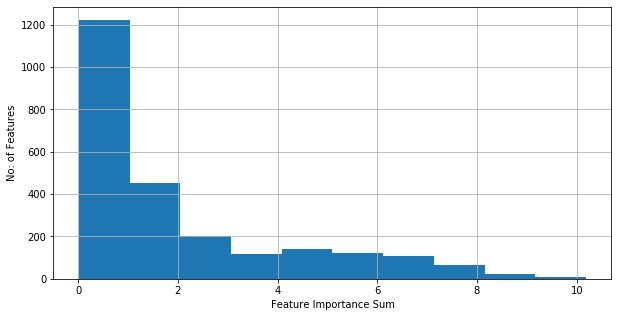

In [10]:
#Plot a histogram of Feature Importance Sum
plt.figure(figsize=(10,5))
plt.xlabel('Feature Importance Sum')
plt.ylabel('No: of Features') 
report_df['feature_imp_sum'].hist()
plt.show()

In [11]:
#classify features into high and low importance
report_df=low_high_imp_grouping(report_df,percentile)
report_df.head()

Feature Importance Report saved as Feature_Importance_Report.csv!! 


,feature,feature_imp_sum,feature_imp_median,feature_imp_mean,rank_sum,rank_median,rank_mean,rank_min,rank_max,feature_count,bucket_first_3,percent_first_3_bucket,best_in_num_games,Group
0,HighLGDN.F,10.188423,0.115057,0.121291,203,2.0,2.416667,1,6,84,66,0.785714,29.0,High
1,Open012700.KQ,9.908865,0.132152,0.139561,127,1.0,1.788732,1,6,71,66,0.929577,39.0,High
2,HighLE6N.BE,9.873231,0.123862,0.129911,162,2.0,2.131579,1,6,76,65,0.855263,30.0,High
3,OpenLFS.BE,9.845781,0.128655,0.131277,149,2.0,1.986667,1,5,75,67,0.893333,32.0,High
4,LowLFY.MU,9.727668,0.114931,0.118630,215,2.0,2.621951,1,11,82,62,0.756098,29.0,High


#### PERFORM VIF TO REMOVE MULTI-COLLINEAR FEATURES

In [12]:
#list of important features
list_of_imp_features = list(report_df[report_df.Group == 'High'].feature)
x_imp = x.loc[:,list_of_imp_features]

#Run vif based feature removal
x_imp_vif = vif_rem(x_imp,r_square_threshold)

238 features dropped after VIF
Dropped variables saved in VIF_Dropped_Report.csv!!


#### APPLY TRANSFOMATIONS AND KEEP BEST FEATURES ONLY

In [13]:
df_transformed=transformations(x_imp_vif,y)

#### RELATIVE FEATURE IMPORTANCE

In [14]:
features_df=gbm(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,df_transformed,y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   18.7s finished


Final best features with their relative importance saved as Best_Features.csv!!


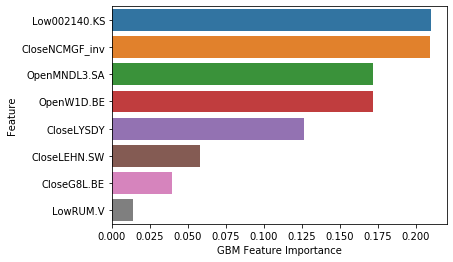

In [15]:
#Bar plot of best features with relative importance
sns.barplot(x='GBM Feature Importance',y='Feature',data=features_df)